In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Constants
TEST_DATA_DIR = 'data/test'
TRAIN_DATA_DIR = 'data/train'
TRAIN_DATA_LABELS = 'data/train.csv'

IMG_WIDTH = 32
IMG_HEIGTH = 32
BATCH_SIZE = 32
GENERATOR_SEED = 1910
EPOCHS = 15

In [3]:
# Data Generator tutorial: https://towardsdatascience.com/keras-data-generators-and-how-to-use-them-b69129ed779c
train_datagen = ImageDataGenerator(validation_split=0.2)
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
    TRAIN_DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGTH),
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode='binary',
    seed=GENERATOR_SEED,
    subset='training'
    )
    
validation_generator = train_datagen.flow_from_directory(
    TRAIN_DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGTH),
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode='binary',
    seed=GENERATOR_SEED,
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGTH),
    color_mode="rgb",
    class_mode=None,
    batch_size=1,
    seed=GENERATOR_SEED,
)

Found 14001 images belonging to 2 classes.
Found 3499 images belonging to 2 classes.
Found 4000 images belonging to 1 classes.


In [4]:
# Build base model.
base_model = Sequential()

base_model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(IMG_HEIGTH, IMG_WIDTH, 3)))
base_model.add(Conv2D(32, kernel_size=3, activation='relu'))
base_model.add(Flatten())
base_model.add(Dense(1, activation='sigmoid'))

In [5]:
base_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
base_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        18464     
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 25089     
Total params: 45,345
Trainable params: 45,345
Non-trainable params: 0
_________________________________________________________________


In [6]:
base_history = base_model.fit(x=train_generator, validation_data=validation_generator, epochs=EPOCHS)

Epoch 1/15
438/438 [==============================] - 25s 56ms/step - loss: 0.8915 - accuracy: 0.8652 - val_loss: 0.2444 - val_accuracy: 0.9400
Epoch 2/15
438/438 [==============================] - 24s 54ms/step - loss: 0.2541 - accuracy: 0.9216 - val_loss: 0.2198 - val_accuracy: 0.9400
Epoch 3/15
438/438 [==============================] - 24s 54ms/step - loss: 0.2446 - accuracy: 0.9139 - val_loss: 0.2250 - val_accuracy: 0.9348
Epoch 4/15
438/438 [==============================] - 23s 54ms/step - loss: 0.2218 - accuracy: 0.9181 - val_loss: 0.2288 - val_accuracy: 0.9366
Epoch 5/15
438/438 [==============================] - 24s 54ms/step - loss: 0.2146 - accuracy: 0.9245 - val_loss: 0.3728 - val_accuracy: 0.8131
Epoch 6/15
438/438 [==============================] - 24s 54ms/step - loss: 0.8214 - accuracy: 0.3023 - val_loss: 0.7160 - val_accuracy: 0.2492
Epoch 7/15
438/438 [==============================] - 24s 54ms/step - loss: 0.6630 - accuracy: 0.6645 - val_loss: 0.6241 - val_accuracy:

In [7]:
# Further evaluation
predictions = base_model.predict_classes(validation_generator)
y_true = validation_generator.classes

report = classification_report(y_true, predictions)
print(report)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
              precision    recall  f1-score   support

           0       0.75      1.00      0.86      2627
           1       0.00      0.00      0.00       872

    accuracy                           0.75      3499
   macro avg       0.38      0.50      0.43      3499
weighted avg       0.56      0.75      0.64      3499



In [8]:
tn, fp, fn, tp = confusion_matrix(y_true, predictions, labels=[0, 1]).ravel()

table = pd.DataFrame({'type': ['True Negative', 'True Positive', 'False Negative', 'True Positive'], 'value': [tn, fp, fn, tp]})
table.head()

,type,value
0,True Negative,2627
1,True Positive,0
2,False Negative,872
3,True Positive,0


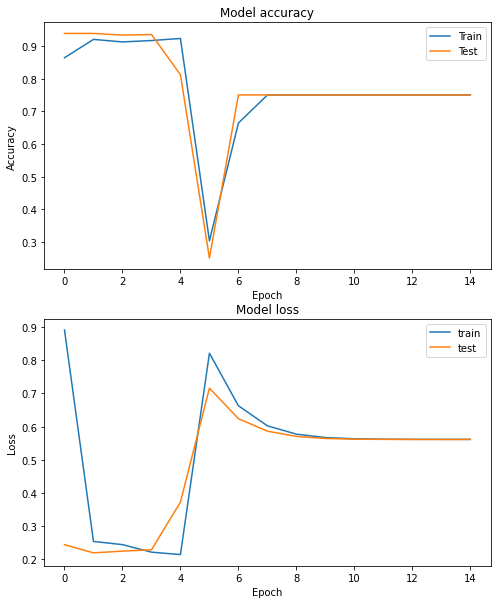

In [9]:
# Visualize accuracy
fig, axes = plt.subplots(2, 1, figsize=(8, 10))


axes[0].plot(base_history.history['accuracy'])
axes[0].plot(base_history.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Test'], loc='upper right')

axes[1].plot(base_history.history['loss'])
axes[1].plot(base_history.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['train', 'test'], loc='upper right')


In [10]:
# Export model
base_model.save('models/base_cnn')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/base_cnn\assets


In [11]:
# TODO: Een aantal voorspellingen maken en laten zien.